In [1]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/CarloSgaravatti/Recsys_Challenge_2023.git

Cloning into 'Recsys_Challenge_2023'...
remote: Enumerating objects: 6394, done.
remote: Counting objects: 100% (1583/1583), done.
remote: Compressing objects: 100% (263/263), done.
remote: Total 6394 (delta 1363), reused 1521 (delta 1311), pack-reused 4811
Receiving objects: 100% (6394/6394), 2.94 GiB | 30.50 MiB/s, done.
Resolving deltas: 100% (5189/5189), done.
Updating files: 100% (511/511), done.


In [2]:
! pip install PyGithub requests

  Obtaining dependency information for PyGithub from https://files.pythonhosted.org/packages/be/04/810d131be173cba445d3658a45512b2b2b3d0960d52c4a300d6ec5e00f52/PyGithub-2.1.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 12.8 MB/s eta 0:00:00


In [3]:
! pip install implicit

  Obtaining dependency information for implicit from https://files.pythonhosted.org/packages/cd/cc/deac70cae8cc32c9885d0cd73bc66e1b3cbea36ae7080b8c83995eaf5322/implicit-0.7.2-cp310-cp310-manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 56.6 MB/s eta 0:00:00


In [4]:
! cd /kaggle/working/Recsys_Challenge_2023 && python run_compile_all_cython.py

run_compile_all_cython: Found 10 Cython files in 4 folders...
run_compile_all_cython: All files will be compiled using your current python environment: '/opt/conda/bin/python'
Compiling [1/10]: MatrixFactorizationImpressions_Cython_Epoch.pyx... 
In file included from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1940,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from MatrixFactorizationImpressions_Cython_Epoch.c:1109:
/opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
MatrixFactorizationImpressions_Cython_Epoch.c: In functio

In [5]:
import numpy as np
from numpy import linalg as LA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import random
import tqdm
import gc
import time
import os
import shutil
import optuna
import scipy.sparse as sps
import scipy.stats as stats
from concurrent.futures import ThreadPoolExecutor

from xgboost import XGBRanker

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/training-tuned-models/als_all.npz
/kaggle/input/training-tuned-models/__results__.html
/kaggle/input/training-tuned-models/ease_r_all.zip
/kaggle/input/training-tuned-models/mult_vae_2_train_validation.zip
/kaggle/input/training-tuned-models/als_xgboost_train_validation.npz
/kaggle/input/training-tuned-models/als_train_validation.npz
/kaggle/input/training-tuned-models/mult_vae_2_xgboost_train_validation.zip
/kaggle/input/training-tuned-models/slim_recall_train_validation.zip
/kaggle/input/training-tuned-models/ease_r_train_validation.zip
/kaggle/input/training-tuned-models/__notebook__.ipynb
/kaggle/input/training-tuned-models/ials_xgboost_train_validation.zip
/kaggle/input/training-tuned-models/ials_train_validation.zip
/kaggle/input/training-tuned-models/mult_vae_2_all.zip
/kaggle/input/training-tuned-models/ease_r_xgboost_train_validation.zip
/kaggle/input/training-tuned-models/__output__.json
/kaggle/input/training-tuned-models/ials_all.zip
/kaggle/input/training-tun

In [6]:
%cd /kaggle/working/Recsys_Challenge_2023

/kaggle/working/Recsys_Challenge_2023


In [7]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender, SLIMElasticNetRecommender
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender, PureSVDItemRecommender, ScaledPureSVDRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.BaseRecommender import BaseRecommender
from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender
from Recommenders.Neural.MultVAERecommender import MultVAERecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.SLIM.SLIM_BPR_Python import SLIM_BPR_Python
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender
from Recommenders.Neural.MultVAERecommender import MultVAERecommender

from Recommenders.Hybrid.LinearCombinationRecommender import LinearCombinationRecommender
from Data_manager.CrossValidationSplitter import CrossValidationSplitter
from Recommenders.MatrixFactorization.ALSImplicitRecommender import ALSImplicitRecommender
from Recommenders.GraphBased.HHPRecommender import HHPRecommender
from Recommenders.GraphBased.TwoWayRankAggregationRecommender import TwoWayRankAggregationRecommender

np.int = int
np.random.seed(42)
np.bool = bool
np.float = float

In [8]:
from github import Github
from github import Auth

auth = Auth.Token(token)
g = Github(auth=auth)

repo = None
for r in g.get_user().get_repos():
    if r.name == 'Recsys_Challenge_2023':
        repo = r
        print('Repository found')

Repository found


In [9]:
def upload_file(filepath_kaggle, filepath_github, commit_message):
    try:
        contents = repo.get_contents(filepath_github)
        with open(filepath_kaggle, "rb") as file:
            repo.update_file(contents.path, commit_message, file.read(), contents.sha)
    except Exception:
        with open(filepath_kaggle, "rb") as file:
            repo.create_file(filepath_github, commit_message, file.read())

In [10]:
config = {
    'tune_parameters': True,
    'n_trials': 25,
    'database_path': '/kaggle/working/tuning_hybrid_xgboost.db',
    'copy_prev_tuning_db': True,
    'copy_prev_best_params': True,
    'save_github': True
}

In [11]:
train_data = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv')
user_ids_test = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv')

In [12]:
URM_all = sps.csr_matrix((train_data.data.values,
                          ((train_data.row - 1).values, (train_data.col - 1).values)),
                        shape=(train_data.row.max(), train_data.col.max()))
URM_all

<13024x22347 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

In [13]:
URM_train_complete, URM_test_complete = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_complete, train_percentage = 0.8)

In [14]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_knn_item.json', 'r') as params_file:
    params_item_knn = json.load(params_file)
params_item_knn

{'topK': 14,
 'shrink': 25,
 'similarity': 'tversky',
 'tversky_alpha': 0.18163095712123836,
 'tversky_beta': 1.8529812241698465}

In [15]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_RP3.json', 'r') as params_file:
    params_rp3 = json.load(params_file)
params_rp3

{'alpha': 0.3408516511081212, 'beta': 0.1447198697205665, 'topK': 32}

In [16]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_knn_user.json', 'r') as params_file:
    params_user_knn = json.load(params_file)
params_user_knn

{'topK': 498,
 'shrink': 0,
 'similarity': 'asymmetric',
 'asymmetric_alpha': 0.39792525383867455}

In [17]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_alpha.json', 'r') as params_file:
    params_p3alpha = json.load(params_file)
params_p3alpha

{'normalize_similarity': 'True',
 'implicit': 'True',
 'alpha': 0.29354071531607107,
 'topK': 49}

In [18]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hybrid_merging.json', 'r') as params_file:
    params_merging = json.load(params_file)
params_merging

{'alpha': 0.3375591188839621, 'topK': 86}

In [19]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hybrid_lr_comb_rp3_p3a_item.json', 'r') as params_file:
    params_lr_comb = json.load(params_file)
params_lr_comb

{'w1': 0.6982294749234325, 'w2': 0.9336649353144076, 'w3': 0.8685182329823133}

In [20]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/pure_svd_params.json', 'r') as params_file:
    params_pure_svd = json.load(params_file)
params_pure_svd

{'factors': 30}

In [21]:
# with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_puresvd_item.json', 'r') as params_file:
#     params_pure_svd_item = json.load(params_file)
params_pure_svd_item = {"topK": 43, "num_factors": 171}

In [22]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_puresvd_scaled.json', 'r') as params_file:
    params_scaled = json.load(params_file)
params_scaled

{'num_factors': 179,
 'scaling_items': 5.3298425368534826e-05,
 'scaling_users': 0.2791990262721904}

In [23]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hhp.json', 'r') as params_file:
    params_hhp = json.load(params_file)
params_hhp

{'hybrid_lambda': 0.8450256587797654, 'topK': 61}

In [24]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_twra.json', 'r') as params_file:
    params = json.load(params_file)

params_twra = {
    'base_f_algorithm': params['base_f_algorithm'], 
    'base_b_algorithm': params['base_b_algorithm'], 
    'convex_lambda': params['convex_lambda'],
}

if params['base_f_algorithm'] == 'p3':
    params_twra['f_params'] = {
        'topK': params['f_p3_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
elif params['base_f_algorithm'] == 'p3alpha':
    params_twra['f_params'] = {
        'alpha': params['f_p3a_alpha'],
        'topK': params['f_p3a_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
elif params['base_f_algorithm'] == 'rp3beta':
    params_twra['f_params'] = {
        'alpha': params['f_rp3_alpha'],
        'beta': params['f_rp3_beta'],
        'topK': params['f_rp3_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
else:
    params_twra['f_params'] = {
        'hybrid_lambda': params['f_hhp_hybrid_lambda'],
        'topK': params['f_hhp_topK'],
    }

if params['base_b_algorithm'] == 'p3':
    params_twra['b_params'] = {
        'topK': params['b_p3_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
elif params['base_b_algorithm'] == 'p3alpha':
    params_twra['b_params'] = {
        'alpha': params['b_p3a_alpha'],
        'topK': params['b_p3a_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
elif params['base_b_algorithm'] == 'rp3beta':
    params_twra['b_params'] = {
        'alpha': params['b_rp3_alpha'],
        'beta': params['b_rp3_beta'],
        'topK': params['b_rp3_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
else:
    params_twra['b_params'] = {
        'hybrid_lambda': params['b_hhp_hybrid_lambda'],
        'topK': params['b_hhp_topK'],
    }

In [25]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_rp3_recall@50.json', 'r') as params_file:
    params_rp3_recall = json.load(params_file)
params_rp3_recall

{'alpha': 0.2139985499567939, 'beta': 0.2194371742883361, 'topK': 154}

In [26]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_item_knn_recall@50.json', 'r') as params_file:
    params_item_knn_recall = json.load(params_file)
params_item_knn_recall

{'topK': 62,
 'shrink': 480,
 'similarity': 'tversky',
 'feature_weighting': 'BM25',
 'tversky_alpha': 0.03679620043176055,
 'tversky_beta': 1.9314395554791928}

In [27]:
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_xgboost_train_validation.zip', 
    '/kaggle/working/ials_xgboost_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_train_validation.zip', 
    '/kaggle/working/ials_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_all.zip', 
    '/kaggle/working/ials_all.zip', 
)

shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_xgboost_train_validation.npz', 
    '/kaggle/working/als_xgboost_train_validation.npz', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_train_validation.npz', 
    '/kaggle/working/als_train_validation.npz', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_all.npz', 
    '/kaggle/working/als_all.npz', 
)

shutil.copyfile(
    '/kaggle/input/training-tuned-models/slim_recall_xgboost_train_validation.zip', 
    '/kaggle/working/slim_recall_xgboost_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/slim_recall_train_validation.zip', 
    '/kaggle/working/slim_recall_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/slim_recall_all.zip', 
    '/kaggle/working/slim_recall_all.zip', 
)

shutil.copyfile(
    '/kaggle/input/training-tuned-models/mult_vae_2_xgboost_train_validation.zip', 
    '/kaggle/working/mult_vae_2_xgboost_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/mult_vae_2_train_validation.zip', 
    '/kaggle/working/mult_vae_2_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/mult_vae_2_all.zip', 
    '/kaggle/working/mult_vae_2_all.zip', 
)

'/kaggle/working/mult_vae_2_all.zip'

In [28]:
recommender_item = ItemKNNCFRecommender(URM_train)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])
user_factors_train = recommender_pure_svd.USER_factors
item_factors_train = recommender_pure_svd.ITEM_factors

recommender_scaled_svd = ScaledPureSVDRecommender(URM_train)
recommender_scaled_svd.fit(**params_scaled)

recommender_pure_svd_item = PureSVDItemRecommender(URM_train)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_train)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_xgboost_train_validation.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_train)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_xgboost_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_xgboost_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_xgboost_train_validation.zip')

recommender_ials = IALSRecommender(URM_train)
recommender_ials.load_model('/kaggle/working/', 'ials_xgboost_train_validation.zip')

recommender_vae = MultVAERecommender(URM_train)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_xgboost_train_validation')

recommender_hhp = HHPRecommender(URM_train)
recommender_hhp.fit(**params_hhp)

recommender_twra = TwoWayRankAggregationRecommender(URM_train)
recommender_twra.fit(**params_twra)

# recommender_als = ALSImplicitRecommender(URM_train)
# recommender_als.load_model('/kaggle/working/', 'als_xgboost_train_validation.npz')

########################## CANDIDATE GENERATORS ##########################

recommender_slim_recall = SLIMElasticNetRecommender(URM_train)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_xgboost_train_validation.zip')

recommender_rp3_recall = RP3betaRecommender(URM_train)
recommender_rp3_recall.fit(**params_rp3_recall)

recommender_item_recall = ItemKNNCFRecommender(URM_train)
recommender_item_recall.fit(**params_item_knn_recall)

ItemKNNCFRecommender: URM Detected 851 ( 6.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 476 ( 2.1%) items with no interactions.
Similarity column 22347 (100.0%), 4784.50 column/sec. Elapsed time 4.67 sec
UserKNNCFRecommender: URM Detected 851 ( 6.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 476 ( 2.1%) items with no interactions.
Similarity column 13024 (100.0%), 5157.93 column/sec. Elapsed time 2.53 sec
RP3betaRecommender: URM Detected 851 ( 6.5%) users with no interactions.
RP3betaRecommender: URM Detected 476 ( 2.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2970.82 column/sec. Elapsed time 7.52 sec
P3alphaRecommender: URM Detected 851 ( 6.5%) users with no interactions.
P3alphaRecommender: URM Detected 476 ( 2.1%) items with no interactions.
P3alphaRecommender: Similarity column 22347 (100.0%), 3252.94 column/sec. Elapsed time 6.87 sec
PureSVDRecommender: URM Detected 851 ( 6.5%) users with no inter

In [29]:
evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions


In [30]:
cutoff = 50
n_users, n_items = URM_train.shape

training_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
training_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations_slim = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    recommendations_knn = recommender_item_recall.recommend(user_id, cutoff = cutoff)
    recommendations_rp3 = recommender_rp3_recall.recommend(user_id, cutoff = cutoff)
    recommendations = np.union1d(recommendations_slim, np.union1d(recommendations_knn, recommendations_rp3))
    if user_id == 0:
        print(recommendations)
    training_dataframe.loc[user_id, "ItemID"] = recommendations
    
training_dataframe = training_dataframe.explode("ItemID")
training_dataframe

/tmp/ipykernel_19/2461008040.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for user_id in tqdm.tqdm_notebook(range(n_users)):


  0%|          | 0/13024 [00:00<?, ?it/s]

[   0    1    2    3    9   28   35   53   57   75   76   84   86   97
  100  101  111  122  136  138  155  170  215  253  256  260  283  288
  336  341  366  402  428  429  505  514  533  591  617  634  636  693
  715  772  849  868  921  976 1056 1067 1082 1088 1131 1213 1222 1287
 1337 1421 1480 1489 1515 1545 1629 1744 1934 2002 2011 2498 2667 2781
 3156 3315 3728 6222 8455 8500]


,ItemID
UserID,
0,0
0,1
0,2
0,3
0,9
...,...
13023,11653
13023,11827
13023,11955


In [31]:
URM_validation_coo = sps.coo_matrix(URM_validation)

correct_recommendations = pd.DataFrame({"UserID": URM_validation_coo.row,
                                        "ItemID": URM_validation_coo.col})
correct_recommendations

,UserID,ItemID
0,0,15
1,0,385
2,0,1934
3,0,4302
4,0,17444
...,...,...
76592,13023,2365
76593,13023,2961
76594,13023,3606
76595,13023,6282


In [32]:
training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
training_dataframe["Label"] = training_dataframe["Exist"] == "both"
training_dataframe.drop(columns = ['Exist'], inplace=True)
training_dataframe

,UserID,ItemID,Label
0,0,0,False
1,0,1,False
2,0,2,False
3,0,3,False
4,0,9,False
...,...,...,...
1067012,13023,11653,False
1067013,13023,11827,False
1067014,13023,11955,False
1067015,13023,13592,False


In [33]:
training_dataframe.Label.sum()

19954

In [34]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    'HHP': recommender_hhp,
    'TWRA': recommender_twra,
    # 'ALS': recommender_als
}

In [35]:
training_dataframe = training_dataframe.set_index('UserID')

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        training_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        training_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        training_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()

item_item_S = recommender_item.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        training_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = 0
    else:
        similarities = item_item_S[training_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        training_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = similarities.mean(axis=1).flatten()
        training_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = similarities.max(axis=1).flatten()
        training_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = similarities.min(axis=1).flatten()
        training_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = similarities.std(axis=1).flatten()
        training_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
        training_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

item_item_S = recommender_rp3.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        training_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = 0
    else:
        similarities = item_item_S[training_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        training_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = similarities.mean(axis=1).flatten()
        training_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = similarities.max(axis=1).flatten()
        training_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = similarities.min(axis=1).flatten()
        training_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = similarities.std(axis=1).flatten()
        training_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = stats.skew(similarities, axis=1)
        training_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

# todo: cluster if possible the similarity matrix of KNN or RP3, then add for each users some features 
# that represent something like users that like only items from the same cluster (e.g. items variability)
# same can be done with users and items reversed (i.e. using User KNN)

recommended_columns = [col for col in training_dataframe.columns if col.endswith('_Recommended')]
training_dataframe['Counter_Recommended'] = training_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in training_dataframe.columns if col.endswith('_RankPosition')]
training_dataframe['Mean_RankPosition'] = training_dataframe[position_columns].mean(axis=1)
training_dataframe['Std_RankPosition'] = training_dataframe[position_columns].std(axis=1)
training_dataframe['Skew_RankPosition'] = training_dataframe[position_columns].skew(axis=1)
training_dataframe['Kurtosis_RankPosition'] = training_dataframe[position_columns].kurtosis(axis=1)

training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
training_dataframe

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

/tmp/ipykernel_19/223847650.py:39: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  training_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
/tmp/ipykernel_19/223847650.py:40: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  training_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)


  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,MaxSimilarityToSeenRP3,MinSimilarityToSeenRP3,StdSimilarityToSeenRP3,SkewSimilarityToSeenRP3,KurtosisSimilarityToSeenRP3,Counter_Recommended,Mean_RankPosition,Std_RankPosition,Skew_RankPosition,Kurtosis_RankPosition
0,0,0,False,0.000000,21981.0,0.0,0.002247,239.0,0.0,0.172726,...,0.000000,0.0,0.000000,NaN,NaN,0,4445.666667,8529.421205,1.690904,1.091150
1,0,1,False,0.000000,7492.0,0.0,0.002246,240.0,0.0,0.000000,...,0.000000,0.0,0.000000,NaN,NaN,0,4343.000000,4470.049600,0.489168,-1.226420
2,0,2,False,0.000000,7493.0,0.0,0.005024,181.0,0.0,0.000000,...,0.000000,0.0,0.000000,NaN,NaN,1,5105.333333,6395.478421,1.250119,1.349319
3,0,3,False,0.000000,7494.0,0.0,0.003501,190.0,0.0,0.000000,...,0.000000,0.0,0.000000,NaN,NaN,0,3841.733333,4173.833344,0.298786,-1.885747
4,0,9,False,0.000000,7499.0,0.0,0.004615,183.0,0.0,0.000000,...,0.000000,0.0,0.000000,NaN,NaN,0,3788.000000,4224.468792,0.373077,-1.696020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1067012,13023,11653,False,0.176484,17.0,0.0,0.124148,146.0,0.0,0.176945,...,0.065990,0.0,0.011571,4.329403,18.561111,0,116.933333,114.431805,0.992899,-0.336770
1067013,13023,11827,False,0.039908,156.0,0.0,0.102497,217.0,0.0,0.000000,...,0.024023,0.0,0.003503,6.559135,41.022263,0,4422.266667,7480.642309,1.583376,0.719424
1067014,13023,11955,False,0.092565,54.0,0.0,0.111171,184.0,0.0,0.077925,...,0.040833,0.0,0.008920,3.700808,12.059912,0,421.600000,570.533309,2.327301,5.760052
1067015,13023,13592,False,0.295934,5.0,1.0,0.102905,214.0,0.0,0.233513,...,0.080118,0.0,0.016885,2.835449,7.682983,5,283.400000,365.269138,1.096526,-0.394693


In [36]:
item_popularity = np.ediff1d(sps.csc_matrix(URM_train).indptr)
item_popularity = item_popularity / np.max(item_popularity)
training_dataframe['item_popularity'] = item_popularity[training_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train).indptr)
user_popularity = user_popularity / np.max(user_popularity)
training_dataframe['user_profile_len'] = user_popularity[training_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_train.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
training_dataframe['mainstream_user'] = mainstream_user[training_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_train.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
training_dataframe['mainstream_item'] = mainstream_item[training_dataframe["ItemID"].values.astype(int)]
training_dataframe

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,KurtosisSimilarityToSeenRP3,Counter_Recommended,Mean_RankPosition,Std_RankPosition,Skew_RankPosition,Kurtosis_RankPosition,item_popularity,user_profile_len,mainstream_user,mainstream_item
0,0,0,False,0.000000,21981.0,0.0,0.002247,239.0,0.0,0.172726,...,NaN,0,4445.666667,8529.421205,1.690904,1.091150,0.886424,0.033573,77.384713,64.370937
1,0,1,False,0.000000,7492.0,0.0,0.002246,240.0,0.0,0.000000,...,NaN,0,4343.000000,4470.049600,0.489168,-1.226420,1.000000,0.033573,77.384713,62.304556
2,0,2,False,0.000000,7493.0,0.0,0.005024,181.0,0.0,0.000000,...,NaN,1,5105.333333,6395.478421,1.250119,1.349319,0.816327,0.033573,77.384713,66.387950
3,0,3,False,0.000000,7494.0,0.0,0.003501,190.0,0.0,0.000000,...,NaN,0,3841.733333,4173.833344,0.298786,-1.885747,0.988465,0.033573,77.384713,68.811732
4,0,9,False,0.000000,7499.0,0.0,0.004615,183.0,0.0,0.000000,...,NaN,0,3788.000000,4224.468792,0.373077,-1.696020,0.507542,0.033573,77.384713,58.666614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1067012,13023,11653,False,0.176484,17.0,0.0,0.124148,146.0,0.0,0.176945,...,18.561111,0,116.933333,114.431805,0.992899,-0.336770,0.007986,0.055156,53.265190,302.245004
1067013,13023,11827,False,0.039908,156.0,0.0,0.102497,217.0,0.0,0.000000,...,41.022263,0,4422.266667,7480.642309,1.583376,0.719424,0.006211,0.055156,53.265190,326.633094
1067014,13023,11955,False,0.092565,54.0,0.0,0.111171,184.0,0.0,0.077925,...,12.059912,0,421.600000,570.533309,2.327301,5.760052,0.005324,0.055156,53.265190,211.481415
1067015,13023,13592,False,0.295934,5.0,1.0,0.102905,214.0,0.0,0.233513,...,7.682983,5,283.400000,365.269138,1.096526,-0.394693,0.004437,0.055156,53.265190,296.209113


In [37]:
user_factors_df = pd.DataFrame(user_factors_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_train[:, :5].shape[1])])

training_dataframe = training_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
training_dataframe = training_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
training_dataframe = training_dataframe.sort_values(by='UserID')
training_dataframe

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,0,False,0.000000,21981.0,0.0,0.002247,239.0,0.0,0.172726,...,0.163921,0.090707,-0.216788,-0.041741,0.056197,0.005684,-0.001896,0.008995,-0.013853,-0.002147
54,0,1222,False,0.000000,7796.0,0.0,0.000932,503.0,0.0,0.000000,...,0.008628,0.004001,0.018486,-0.012392,0.001480,0.005684,-0.001896,0.008995,-0.013853,-0.002147
53,0,1213,False,0.215692,16.0,0.0,0.069173,45.0,0.0,0.119938,...,0.007796,-0.009614,0.002953,-0.000483,-0.004862,0.005684,-0.001896,0.008995,-0.013853,-0.002147
52,0,1131,False,0.170961,21.0,0.0,0.000908,520.0,0.0,0.079453,...,0.008328,-0.008771,0.024645,0.012543,0.037796,0.005684,-0.001896,0.008995,-0.013853,-0.002147
51,0,1088,False,0.211910,17.0,0.0,0.000463,1199.0,0.0,0.095478,...,0.011467,-0.011217,0.021460,0.020043,0.052159,0.005684,-0.001896,0.008995,-0.013853,-0.002147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1066973,13023,695,False,0.051093,114.0,0.0,0.344100,10.0,0.0,0.000000,...,0.011910,-0.020622,0.017123,0.012590,0.042566,0.006896,-0.007143,0.001571,0.006195,0.023549
1066971,13023,605,True,0.057563,100.0,0.0,0.203670,56.0,0.0,0.061681,...,0.016095,-0.028862,0.009837,0.013453,0.047040,0.006896,-0.007143,0.001571,0.006195,0.023549
1066968,13023,407,False,0.000000,7195.0,0.0,0.277303,23.0,0.0,0.000000,...,0.019528,-0.040613,0.013791,0.005590,0.052483,0.006896,-0.007143,0.001571,0.006195,0.023549
1066979,13023,1068,False,0.158385,18.0,0.0,0.194655,65.0,0.0,0.145328,...,0.010152,-0.018598,0.011308,0.011311,0.036143,0.006896,-0.007143,0.001571,0.006195,0.023549


In [38]:
n_estimators = 500
learning_rate = 1e-1
reg_alpha = 1e-1
reg_lambda = 1e-1
max_depth = 5
max_leaves = 32
grow_policy = "depthwise"
objective = "map"  #"pairwise", "ndcg"
booster = "gbtree"
use_user_profile = False
random_seed = None

XGB_model = XGBRanker(
    objective='rank:{}'.format(objective),
    n_estimators = int(n_estimators),
    random_state = random_seed,
    learning_rate = learning_rate,
    reg_alpha = reg_alpha,
    reg_lambda = reg_lambda,
    max_depth = int(max_depth),
    max_leaves = int(max_leaves),
    grow_policy = grow_policy,
    verbosity = 1, # 2 if self.verbose else 0,
    booster = booster,
    # enable_categorical = True
)

In [39]:
groups = training_dataframe.groupby("UserID").size().values
groups

array([76, 71, 77, ..., 92, 73, 69])

In [40]:
y_train = training_dataframe["Label"]
X_train = training_dataframe.drop(columns=["Label", "UserID", "ItemID"])
# X_train["UserID"] = X_train["UserID"].astype("category")
# X_train["ItemID"] = X_train["ItemID"].astype("category")
# X_train["UserID"] = X_train["UserID"].astype(int)
# X_train["ItemID"] = X_train["ItemID"].astype(int)

# object_columns = X_train.select_dtypes(include=['object']).columns
# X_train[object_columns] = X_train[object_columns].astype('category')

XGB_model.fit(
    X_train,
    y_train,
    group=groups,
    verbose=True
)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None,
          device=None, early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=None,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.1, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=5, max_leaves=32, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=500,
          n_jobs=None, num_parallel_tree=None, objective='rank:map', ...)

<Axes: title={'center': 'Feature Importance (Weight)'}, xlabel='F score', ylabel='Features'>

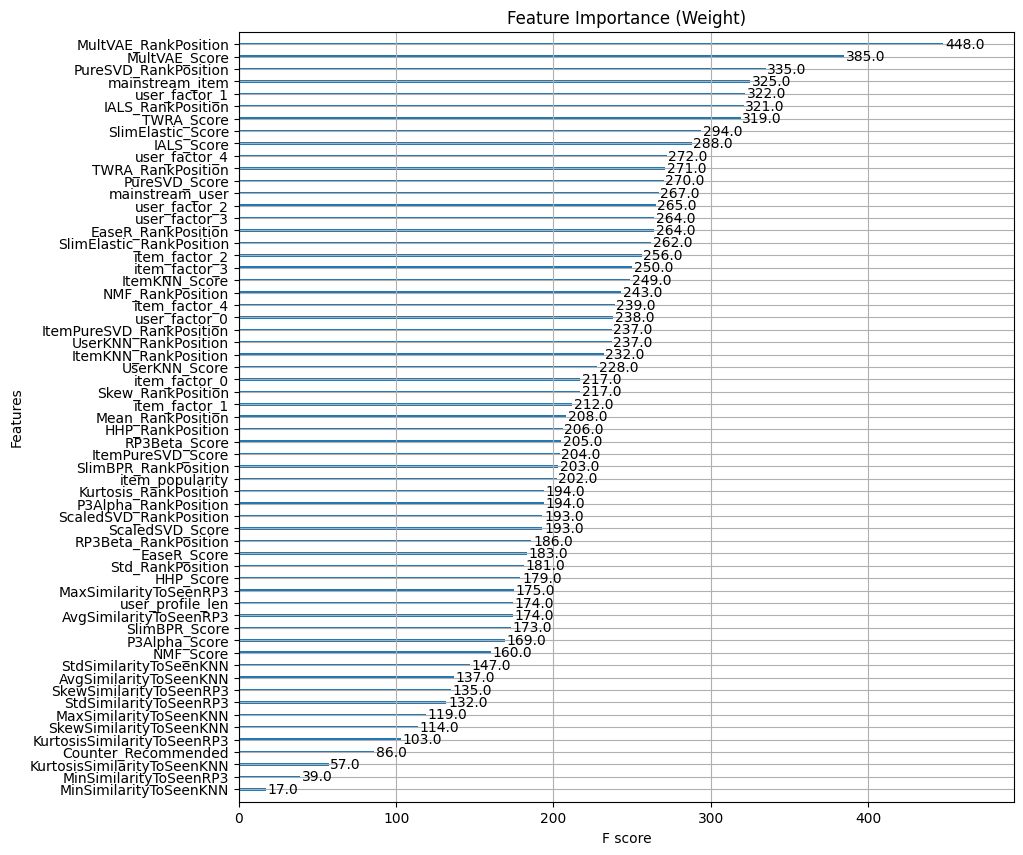

In [41]:
from xgboost import plot_importance

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(XGB_model, importance_type='weight', title='Feature Importance (Weight)', ax=ax)

<Axes: title={'center': 'Feature Importance (Cover)'}, xlabel='F score', ylabel='Features'>

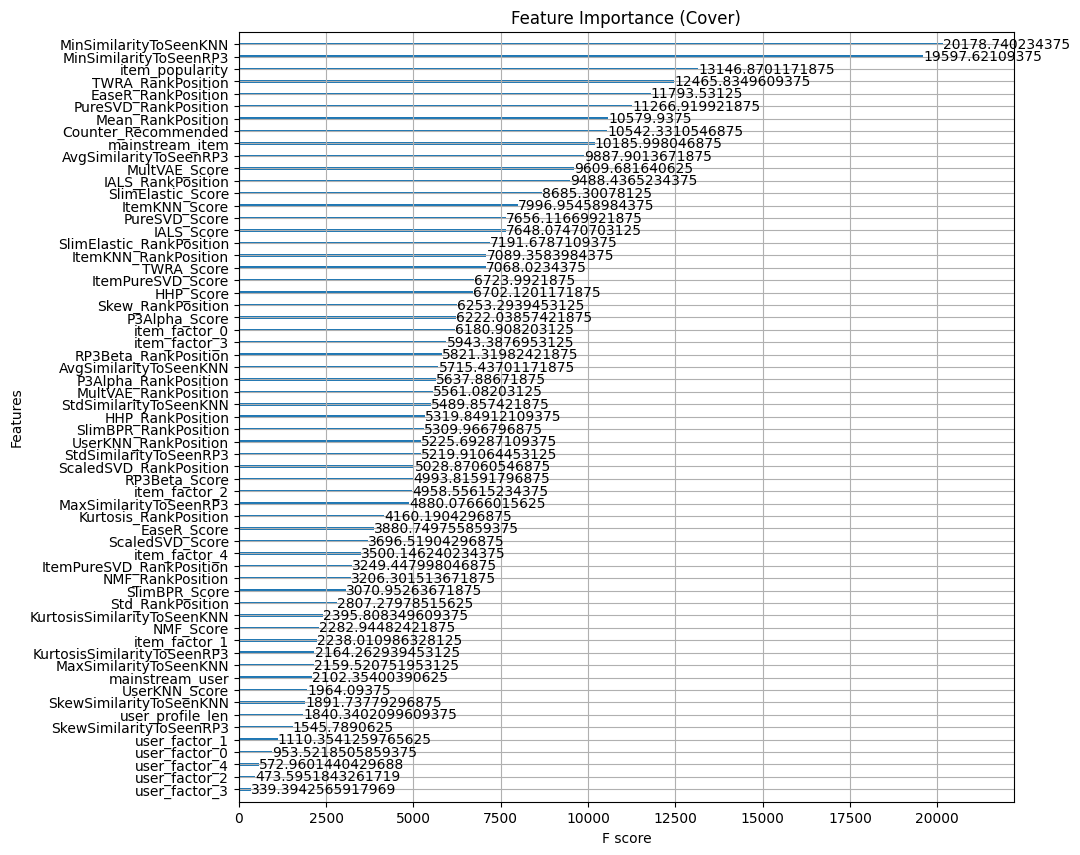

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(XGB_model, importance_type='cover', title='Feature Importance (Cover)', ax=ax)

<Axes: title={'center': 'Feature Importance (Gain)'}, xlabel='F score', ylabel='Features'>

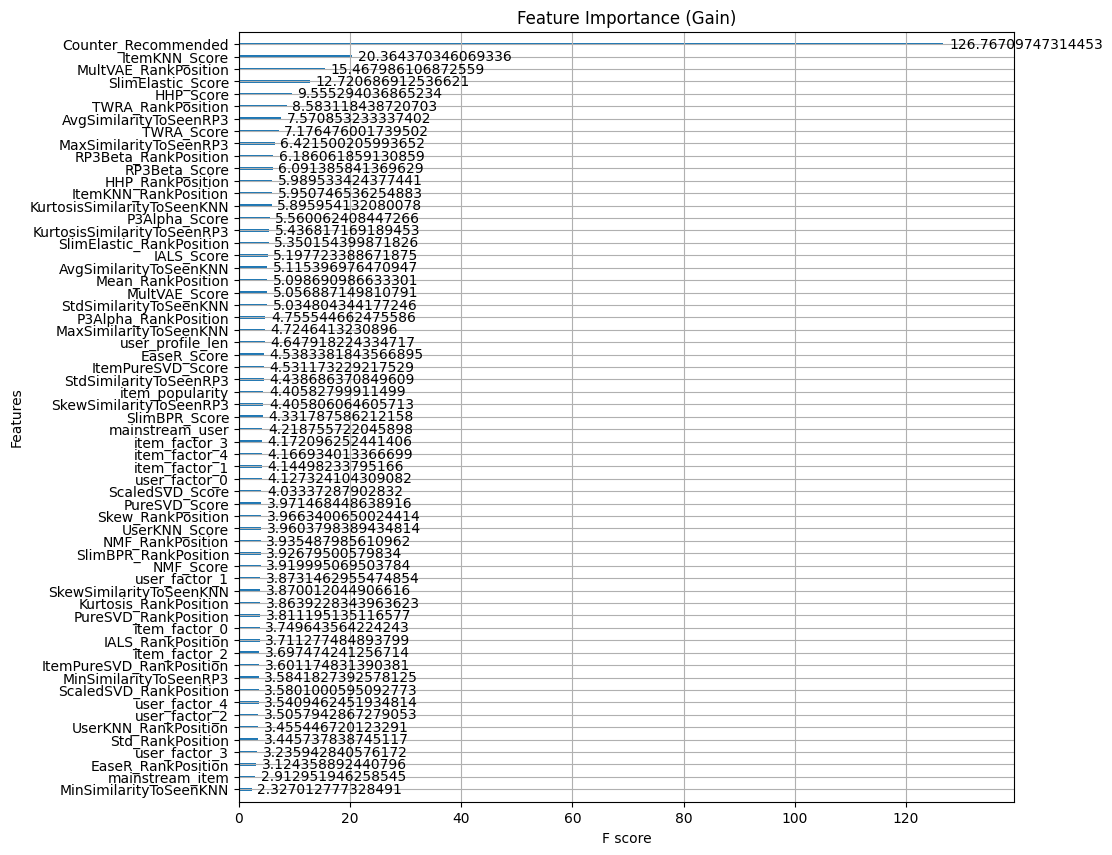

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(XGB_model, importance_type='gain', title='Feature Importance (Gain)', ax=ax)

In [44]:
recommender_item = ItemKNNCFRecommender(URM_train_complete)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train_complete)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train_complete)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train_complete)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train_complete)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])

recommender_scaled_svd = ScaledPureSVDRecommender(URM_train_complete)
recommender_scaled_svd.fit(**params_scaled)

recommender_pure_svd_item = PureSVDItemRecommender(URM_train_complete)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_train_complete)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_train_validation.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_train_complete)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train_complete)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_train_validation.zip')

recommender_ials = IALSRecommender(URM_train_complete)
recommender_ials.load_model('/kaggle/working/', 'ials_train_validation.zip')

recommender_vae = MultVAERecommender(URM_train_complete)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_train_validation')

recommender_hhp = HHPRecommender(URM_train_complete)
recommender_hhp.fit(**params_hhp)

recommender_twra = TwoWayRankAggregationRecommender(URM_train_complete)
recommender_twra.fit(**params_twra)

# recommender_als = ALSImplicitRecommender(URM_train_complete)
# recommender_als.load_model('/kaggle/working/', 'als_train_validation.npz')

########################## CANDIDATE GENERATORS ##########################

recommender_slim_recall = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_train_validation.zip')

recommender_rp3_recall = RP3betaRecommender(URM_train_complete)
recommender_rp3_recall.fit(**params_rp3_recall)

recommender_item_recall = ItemKNNCFRecommender(URM_train_complete)
recommender_item_recall.fit(**params_item_knn_recall)

ItemKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Similarity column 22347 (100.0%), 4542.86 column/sec. Elapsed time 4.92 sec
UserKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4615.22 column/sec. Elapsed time 2.82 sec
RP3betaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
RP3betaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2635.44 column/sec. Elapsed time 8.48 sec
P3alphaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
P3alphaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
P3alphaRecommender: Similarity column 22347 (100.0%), 2892.26 column/sec. Elapsed time 7.73 sec
PureSVDRecommender: URM Detected 627 ( 4.8%) users with no inter

In [45]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    'HHP': recommender_hhp,
    'TWRA': recommender_twra,
    # 'ALS': recommender_als
}

In [46]:
cutoff = 50
n_users, n_items = URM_train_complete.shape

validation_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
validation_dataframe.index.name='UserID'

for user_id in tqdm.auto.tqdm(range(n_users)):    
    recommendations_slim = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    recommendations_knn = recommender_item_recall.recommend(user_id, cutoff = cutoff)
    recommendations_rp3 = recommender_rp3_recall.recommend(user_id, cutoff = cutoff)
    recommendations = np.union1d(recommendations_slim, np.union1d(recommendations_knn, recommendations_rp3))
    validation_dataframe.loc[user_id, "ItemID"] = recommendations
    
validation_dataframe = validation_dataframe.explode("ItemID")

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = validation_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        validation_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        validation_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        validation_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()
    
item_item_S = recommender_item.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        validation_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = 0
    else:
        similarities = item_item_S[validation_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        validation_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = similarities.mean(axis=1).flatten()
        validation_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = similarities.max(axis=1).flatten()
        validation_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = similarities.min(axis=1).flatten()
        validation_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = similarities.std(axis=1).flatten()
        validation_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
        validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

item_item_S = recommender_rp3.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        validation_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = 0
    else:
        similarities = item_item_S[validation_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        validation_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = similarities.mean(axis=1).flatten()
        validation_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = similarities.max(axis=1).flatten()
        validation_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = similarities.min(axis=1).flatten()
        validation_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = similarities.std(axis=1).flatten()
        validation_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = stats.skew(similarities, axis=1)
        validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()
    
validation_dataframe = validation_dataframe.reset_index()
validation_dataframe = validation_dataframe.rename(columns = {"index": "UserID"})

recommended_columns = [col for col in validation_dataframe.columns if col.endswith('_Recommended')]
validation_dataframe['Counter_Recommended'] = validation_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in validation_dataframe.columns if col.endswith('_RankPosition')]
validation_dataframe['Mean_RankPosition'] = validation_dataframe[position_columns].mean(axis=1)
validation_dataframe['Std_RankPosition'] = validation_dataframe[position_columns].std(axis=1)
validation_dataframe['Skew_RankPosition'] = validation_dataframe[position_columns].skew(axis=1)
validation_dataframe['Kurtosis_RankPosition'] = validation_dataframe[position_columns].kurtosis(axis=1)

item_popularity = np.ediff1d(sps.csc_matrix(URM_train_complete).indptr)
item_popularity = item_popularity / np.max(item_popularity)
validation_dataframe['item_popularity'] = item_popularity[validation_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train_complete).indptr)
user_popularity = user_popularity / np.max(user_popularity)
validation_dataframe['user_profile_len'] = user_popularity[validation_dataframe["UserID"].values.astype(int)]
validation_dataframe

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

/tmp/ipykernel_19/626954395.py:52: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  validation_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
/tmp/ipykernel_19/626954395.py:53: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)


  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,P3Alpha_RankPosition,...,StdSimilarityToSeenRP3,SkewSimilarityToSeenRP3,KurtosisSimilarityToSeenRP3,Counter_Recommended,Mean_RankPosition,Std_RankPosition,Skew_RankPosition,Kurtosis_RankPosition,item_popularity,user_profile_len
0,0,0,0.000000,22303.0,0.0,0.005663,133.0,0.0,0.000000,22283.0,...,0.000000,NaN,NaN,0,9161.133333,11034.608795,0.438419,-2.085587,0.886121,0.032075
1,0,1,0.000000,7499.0,0.0,0.010246,60.0,0.0,0.000000,7477.0,...,0.000000,NaN,NaN,0,2885.733333,3500.712631,0.552869,-1.858036,1.000000,0.032075
2,0,2,0.000000,7500.0,0.0,0.010817,58.0,0.0,0.000000,7478.0,...,0.000000,NaN,NaN,1,6237.600000,6386.778987,0.997782,1.376678,0.811388,0.032075
3,0,3,0.000000,7501.0,0.0,0.012973,51.0,0.0,0.000000,7479.0,...,0.000000,NaN,NaN,0,4538.666667,5393.305780,1.002611,0.534822,0.973665,0.032075
4,0,7,0.189751,24.0,0.0,0.008546,73.0,0.0,0.113997,12.0,...,0.000000,NaN,NaN,1,1604.933333,4586.695721,3.231686,10.715886,0.692527,0.032075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1055398,13023,10912,0.124691,41.0,0.0,0.077127,408.0,0.0,0.030217,154.0,...,0.011540,2.528026,4.419128,0,2355.066667,4825.602456,3.269872,11.517487,0.004982,0.056604
1055399,13023,11018,0.149842,36.0,0.0,0.163464,120.0,0.0,0.147351,30.0,...,0.011594,2.325696,3.618560,0,171.733333,255.100111,1.943374,2.761437,0.004982,0.056604
1055400,13023,11653,0.248895,16.0,0.0,0.164520,118.0,0.0,0.305779,12.0,...,0.013050,3.435117,10.790638,2,115.800000,167.459675,2.053184,4.202460,0.007117,0.056604
1055401,13023,11955,0.260745,15.0,0.0,0.157063,126.0,0.0,0.138857,32.0,...,0.014879,2.872438,6.805297,0,194.533333,377.837241,2.745526,7.327920,0.004982,0.056604


In [47]:
mainstream_user = URM_train_complete.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
validation_dataframe['mainstream_user'] = mainstream_user[validation_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_train_complete.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
validation_dataframe['mainstream_item'] = mainstream_item[validation_dataframe["ItemID"].values.astype(int)]

user_factors_df = pd.DataFrame(user_factors_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_train[:, :5].shape[1])])
validation_dataframe = validation_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
validation_dataframe = validation_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
validation_dataframe = validation_dataframe.sort_values(by='UserID')

validation_dataframe

,UserID,ItemID,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,P3Alpha_RankPosition,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,0,0.000000,22303.0,0.0,0.005663,133.0,0.0,0.000000,22283.0,...,0.163921,0.090707,-0.216788,-0.041741,0.056197,0.005684,-0.001896,0.008995,-0.013853,-0.002147
60,0,1257,0.113153,50.0,0.0,0.002463,460.0,0.0,0.055753,56.0,...,0.009264,0.007807,0.009192,0.015810,0.004970,0.005684,-0.001896,0.008995,-0.013853,-0.002147
59,0,1213,0.219015,17.0,0.0,0.004029,208.0,0.0,0.086829,25.0,...,0.007796,-0.009614,0.002953,-0.000483,-0.004862,0.005684,-0.001896,0.008995,-0.013853,-0.002147
58,0,1088,0.206087,20.0,0.0,0.000000,9783.0,0.0,0.063827,43.0,...,0.011467,-0.011217,0.021460,0.020043,0.052159,0.005684,-0.001896,0.008995,-0.013853,-0.002147
57,0,1082,0.261194,14.0,0.0,0.003559,265.0,0.0,0.101984,16.0,...,0.008902,-0.013901,0.005310,0.008307,0.003830,0.005684,-0.001896,0.008995,-0.013853,-0.002147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1055380,13023,2152,0.000000,5872.0,0.0,0.216950,65.0,0.0,0.000000,5857.0,...,0.004974,-0.014541,0.004915,0.004194,0.023232,0.006896,-0.007143,0.001571,0.006195,0.023549
1055379,13023,2119,0.487735,4.0,1.0,0.364687,11.0,0.0,0.439395,7.0,...,0.003394,-0.009902,0.004116,0.002884,0.015884,0.006896,-0.007143,0.001571,0.006195,0.023549
1055381,13023,2195,0.296294,11.0,0.0,0.290332,27.0,0.0,0.251844,15.0,...,0.004869,-0.011313,0.006562,-0.000144,0.018232,0.006896,-0.007143,0.001571,0.006195,0.023549
1055377,13023,1791,0.034666,147.0,0.0,0.248859,40.0,0.0,0.050318,88.0,...,0.006689,-0.014163,0.015855,0.009517,0.029980,0.006896,-0.007143,0.001571,0.006195,0.023549


In [48]:
# validation_dataframe["UserID"] = validation_dataframe["UserID"].astype("category")
# validation_dataframe["ItemID"] = validation_dataframe["ItemID"].astype("category")

validation_dataframe["UserID"] = validation_dataframe["UserID"].astype(int)
validation_dataframe["ItemID"] = validation_dataframe["ItemID"].astype(int)

# object_columns = validation_dataframe.select_dtypes(include=['object']).columns
# validation_dataframe[object_columns] = validation_dataframe[object_columns].astype('category')

In [49]:
class XGBoostRerankerRecommender:
    def __init__(self, URM_train, XGB_model, df):
        self.URM_train = URM_train
        self.df = df
        self.XGB_model = XGB_model
        
    def recommend(self, user_ids, cutoff=10, return_scores=True, remove_seen_flag=True, remove_top_pop_flag=True, remove_custom_items_flag=False):
        recommendations = []
        for user_id in user_ids:
            df_slice = self.df[self.df['UserID'] == user_id]
            items = df_slice.ItemID.to_numpy()
            preds = self.XGB_model.predict(df_slice.drop(columns=["UserID", "ItemID"]))
            recommendations.append(items[np.argsort(preds)[-cutoff:][::-1]].tolist())
            
        if return_scores:
            rec, scores = recommender_item.recommend(user_ids, cutoff=cutoff, return_scores=return_scores)
            # useless scores
            return np.array(recommendations), scores
        return np.array(recommendations)
    
    def get_URM_train(self):
        return self.URM_train

In [50]:
recommender = XGBoostRerankerRecommender(URM_train_complete, XGB_model, validation_dataframe)
result_df, _ = evaluator.evaluateRecommender(recommender)
result_df

EvaluatorHoldout: Processed 10456 (100.0%) in 4.17 min. Users per second: 42


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.099149,0.171862,0.145197,0.049036,0.083062,0.269907,0.152601,0.117834,0.537777,0.359108,...,0.802826,0.431741,0.802826,0.054371,10.003727,0.996624,0.156881,0.770648,2.122282,0.292788


In [51]:
def objective_xgboost(trial):

    XGB_model = XGBRanker(
        objective = trial.suggest_categorical('objective', ["rank:map", "rank:pairwise", "rank:ndcg"]),
        n_estimators = trial.suggest_int('n_estimators', 10, 5000, log=True),
        learning_rate = trial.suggest_float('learning_rate', 1e-4, 0.5, log=True),
        reg_alpha = trial.suggest_float('reg_alpha', 1e-5, 1, log=True),
        reg_lambda = trial.suggest_float('reg_lambda', 1e-5, 1, log=True),
        max_depth = trial.suggest_int('max_depth', 3, 20),
        max_leaves = trial.suggest_int('max_leaves', 8, 1024),
        grow_policy = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        verbosity = 2,
        booster = 'gbtree',
        # tree_method = trial.suggest_categorical('tree_method', ['exact', 'approx', 'hist']),
        tree_method = 'hist',
        gamma = trial.suggest_float('gamma', 1e-7, 10, log=True),
        min_child_weight = trial.suggest_float('min_child_weight', 1e-7, 1, log=True),
        subsample = trial.suggest_float('subsample', 0.1, 0.9),
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 0.9),
        # enable_categorical = True
    )
    
    XGB_model.fit(
        X_train,
        y_train,
        group=groups,
        verbose=True
    )
    
    recommender = XGBoostRerankerRecommender(URM_train_complete, XGB_model, validation_dataframe)
    result_df, _ = evaluator.evaluateRecommender(recommender)
        
    return result_df.loc[10, 'MAP']

In [52]:
try:
    shutil.copyfile(
        '/kaggle/working/Recsys_Challenge_2023/tuning_results/tuning_hybrid_xgboost_no_ids.db', 
        config['database_path']
    )
except FileNotFoundError:
    pass

In [53]:
if config['tune_parameters']:
    study = optuna.create_study(direction='maximize', study_name='xgboost_tuning_v2', 
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_xgboost, n_trials=config['n_trials'])

[I 2023-12-28 20:09:59,666] Using an existing study with name 'xgboost_tuning_v2' instead of creating a new one.


EvaluatorHoldout: Processed 10456 (100.0%) in 5.21 min. Users per second: 33


[I 2023-12-28 20:21:44,486] Trial 45 finished with value: 0.05184865376908271 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 695, 'learning_rate': 0.0019098137484329987, 'reg_alpha': 0.0001341480415834446, 'reg_lambda': 0.19961617320652622, 'max_depth': 14, 'max_leaves': 381, 'grow_policy': 'lossguide', 'gamma': 2.254180964802231e-05, 'min_child_weight': 0.488791669107101, 'subsample': 0.8990870652832486, 'colsample_bytree': 0.42107565548846804}. Best is trial 41 with value: 0.052427693979913356.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.46 min. Users per second: 39


[I 2023-12-28 20:29:58,486] Trial 46 finished with value: 0.05238598101189015 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 396, 'learning_rate': 0.0006044306558817779, 'reg_alpha': 0.00012677541995519923, 'reg_lambda': 0.13930942297054213, 'max_depth': 16, 'max_leaves': 291, 'grow_policy': 'lossguide', 'gamma': 1.0610783743550302e-05, 'min_child_weight': 0.033543035893934446, 'subsample': 0.7948951267179093, 'colsample_bytree': 0.2992897117621484}. Best is trial 41 with value: 0.052427693979913356.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.14 min. Users per second: 42


[I 2023-12-28 20:36:40,345] Trial 47 finished with value: 0.05211101926743703 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 333, 'learning_rate': 0.0005482975274097034, 'reg_alpha': 5.676881104507255e-05, 'reg_lambda': 0.13603752772614022, 'max_depth': 16, 'max_leaves': 215, 'grow_policy': 'depthwise', 'gamma': 1.4075281755347301e-05, 'min_child_weight': 0.03819520362194086, 'subsample': 0.7957249918461856, 'colsample_bytree': 0.2770142065238865}. Best is trial 41 with value: 0.052427693979913356.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.51 min. Users per second: 39


[I 2023-12-28 20:45:03,009] Trial 48 finished with value: 0.052332673728762706 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 357, 'learning_rate': 0.00014579529689940163, 'reg_alpha': 0.00013419632482401824, 'reg_lambda': 0.03201658856838785, 'max_depth': 18, 'max_leaves': 453, 'grow_policy': 'lossguide', 'gamma': 2.894417197990381e-06, 'min_child_weight': 0.08433639996301422, 'subsample': 0.8700944990488351, 'colsample_bytree': 0.3132911828721705}. Best is trial 41 with value: 0.052427693979913356.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.29 min. Users per second: 41


[I 2023-12-28 20:53:26,165] Trial 49 finished with value: 0.05232275688903509 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 652, 'learning_rate': 0.0007454894173634269, 'reg_alpha': 6.102052432926515e-05, 'reg_lambda': 0.23374626501000725, 'max_depth': 7, 'max_leaves': 520, 'grow_policy': 'lossguide', 'gamma': 4.1944067561117955e-07, 'min_child_weight': 0.014522352451207598, 'subsample': 0.7697210451915938, 'colsample_bytree': 0.28827335783571234}. Best is trial 41 with value: 0.052427693979913356.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.09 min. Users per second: 43


[I 2023-12-28 20:59:40,520] Trial 50 finished with value: 0.05225033701315323 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 263, 'learning_rate': 0.00033946161249616045, 'reg_alpha': 0.0001260274014908073, 'reg_lambda': 0.5045806212896508, 'max_depth': 16, 'max_leaves': 147, 'grow_policy': 'lossguide', 'gamma': 5.095790297437042e-05, 'min_child_weight': 0.038561865040597935, 'subsample': 0.6667790239234259, 'colsample_bytree': 0.37828143530905795}. Best is trial 41 with value: 0.052427693979913356.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.39 min. Users per second: 40


[I 2023-12-28 21:07:14,758] Trial 51 finished with value: 0.05238335094303003 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 346, 'learning_rate': 0.0005671967145633354, 'reg_alpha': 0.0009291001643663635, 'reg_lambda': 0.12518808408153143, 'max_depth': 11, 'max_leaves': 293, 'grow_policy': 'lossguide', 'gamma': 1.385650365169877e-05, 'min_child_weight': 0.9943333143084376, 'subsample': 0.8734601107902873, 'colsample_bytree': 0.3315817486934922}. Best is trial 41 with value: 0.052427693979913356.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.35 min. Users per second: 40


[I 2023-12-28 21:14:52,829] Trial 52 finished with value: 0.052362109246912765 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 369, 'learning_rate': 0.0005283798344978892, 'reg_alpha': 0.0007139422939687372, 'reg_lambda': 0.12680895987689503, 'max_depth': 11, 'max_leaves': 305, 'grow_policy': 'lossguide', 'gamma': 1.166837133822838e-05, 'min_child_weight': 0.14369588798853825, 'subsample': 0.8741603356838439, 'colsample_bytree': 0.32375464532867837}. Best is trial 41 with value: 0.052427693979913356.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.06 min. Users per second: 43


[I 2023-12-28 21:21:01,270] Trial 53 finished with value: 0.05249106611530147 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 253, 'learning_rate': 0.0008860784159971346, 'reg_alpha': 0.0001876769629147304, 'reg_lambda': 0.5950471409374396, 'max_depth': 9, 'max_leaves': 243, 'grow_policy': 'lossguide', 'gamma': 3.7139783988307417e-06, 'min_child_weight': 0.5338760147183548, 'subsample': 0.8990473870649197, 'colsample_bytree': 0.3381304417973329}. Best is trial 53 with value: 0.05249106611530147.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.12 min. Users per second: 42


[I 2023-12-28 21:27:18,147] Trial 54 finished with value: 0.05252407291021535 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 266, 'learning_rate': 0.0009869509136246134, 'reg_alpha': 0.00017088723733099873, 'reg_lambda': 0.5137280031256188, 'max_depth': 9, 'max_leaves': 234, 'grow_policy': 'lossguide', 'gamma': 3.277258055203449e-06, 'min_child_weight': 0.5195950113217487, 'subsample': 0.8128690737876132, 'colsample_bytree': 0.37783436814658355}. Best is trial 54 with value: 0.05252407291021535.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.08 min. Users per second: 43


[I 2023-12-28 21:33:24,359] Trial 55 finished with value: 0.05242117004287101 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 246, 'learning_rate': 0.001868879259541379, 'reg_alpha': 0.00019567901022139646, 'reg_lambda': 0.6520597684528653, 'max_depth': 9, 'max_leaves': 253, 'grow_policy': 'lossguide', 'gamma': 3.5674463720855465e-06, 'min_child_weight': 0.4008555675688784, 'subsample': 0.8169855598074328, 'colsample_bytree': 0.37361039024569687}. Best is trial 54 with value: 0.05252407291021535.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.05 min. Users per second: 43


[I 2023-12-28 21:39:10,730] Trial 56 finished with value: 0.052199473834420744 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 254, 'learning_rate': 0.0016946429929611039, 'reg_alpha': 0.00027898389377061953, 'reg_lambda': 0.6169706088913223, 'max_depth': 8, 'max_leaves': 63, 'grow_policy': 'lossguide', 'gamma': 2.167475114405843e-06, 'min_child_weight': 0.16397641308676736, 'subsample': 0.8221786560416854, 'colsample_bytree': 0.4278507371850583}. Best is trial 54 with value: 0.05252407291021535.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.13 min. Users per second: 42


[I 2023-12-28 21:45:17,778] Trial 57 finished with value: 0.05183743138290823 and parameters: {'objective': 'rank:map', 'n_estimators': 236, 'learning_rate': 0.002329160654920783, 'reg_alpha': 0.00019157115165788403, 'reg_lambda': 0.6306048134897815, 'max_depth': 9, 'max_leaves': 183, 'grow_policy': 'lossguide', 'gamma': 4.3060899138619105e-06, 'min_child_weight': 0.559602058624125, 'subsample': 0.8138964881891584, 'colsample_bytree': 0.3956300390452434}. Best is trial 54 with value: 0.05252407291021535.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.95 min. Users per second: 44


[I 2023-12-28 21:50:07,012] Trial 58 finished with value: 0.05223222255619967 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 127, 'learning_rate': 0.0013829413392422807, 'reg_alpha': 0.00041562848043012296, 'reg_lambda': 0.6386105629029736, 'max_depth': 6, 'max_leaves': 245, 'grow_policy': 'depthwise', 'gamma': 1.3640557020466552e-06, 'min_child_weight': 0.5246641502982984, 'subsample': 0.7442745424778328, 'colsample_bytree': 0.34602503804511425}. Best is trial 54 with value: 0.05252407291021535.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.96 min. Users per second: 44


[I 2023-12-28 21:55:12,912] Trial 59 finished with value: 0.05219742822530743 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 161, 'learning_rate': 0.002642307402954964, 'reg_alpha': 0.00019670723733555595, 'reg_lambda': 0.3115219719014328, 'max_depth': 7, 'max_leaves': 150, 'grow_policy': 'lossguide', 'gamma': 3.5624716854615263e-07, 'min_child_weight': 0.24578374974221662, 'subsample': 0.8988151815675143, 'colsample_bytree': 0.37154814632030436}. Best is trial 54 with value: 0.05252407291021535.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.39 min. Users per second: 40


[I 2023-12-28 22:03:24,892] Trial 60 finished with value: 0.052206240663825294 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 535, 'learning_rate': 0.004361314662169688, 'reg_alpha': 0.0005390508659967218, 'reg_lambda': 0.7059812778770862, 'max_depth': 9, 'max_leaves': 173, 'grow_policy': 'lossguide', 'gamma': 5.427846371620752e-06, 'min_child_weight': 0.10652605980447626, 'subsample': 0.7129719211108457, 'colsample_bytree': 0.4516038712747022}. Best is trial 54 with value: 0.05252407291021535.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.13 min. Users per second: 42


[I 2023-12-28 22:09:40,505] Trial 61 finished with value: 0.052276208844925696 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 283, 'learning_rate': 0.0009809838533994238, 'reg_alpha': 0.00015204081593735115, 'reg_lambda': 0.35243555490540707, 'max_depth': 8, 'max_leaves': 378, 'grow_policy': 'lossguide', 'gamma': 1.5209447819473272e-06, 'min_child_weight': 0.5739011974932413, 'subsample': 0.8678853812992645, 'colsample_bytree': 0.34653999028782934}. Best is trial 54 with value: 0.05252407291021535.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.13 min. Users per second: 42


[I 2023-12-28 22:15:40,838] Trial 62 finished with value: 0.05232059362893392 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 221, 'learning_rate': 0.001964399054643782, 'reg_alpha': 0.000295718519314486, 'reg_lambda': 0.24108994467968323, 'max_depth': 10, 'max_leaves': 250, 'grow_policy': 'lossguide', 'gamma': 3.818322621500862e-06, 'min_child_weight': 0.22561044821758217, 'subsample': 0.8559167727338365, 'colsample_bytree': 0.295165726089767}. Best is trial 54 with value: 0.05252407291021535.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.36 min. Users per second: 40


[I 2023-12-28 22:23:05,740] Trial 63 finished with value: 0.05230153037369043 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 298, 'learning_rate': 0.0008362842633852458, 'reg_alpha': 7.209710312754273e-05, 'reg_lambda': 0.4363869002931302, 'max_depth': 12, 'max_leaves': 419, 'grow_policy': 'lossguide', 'gamma': 7.817244025124624e-07, 'min_child_weight': 0.4530606041043459, 'subsample': 0.8200439777975863, 'colsample_bytree': 0.39510521723594416}. Best is trial 54 with value: 0.05252407291021535.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.16 min. Users per second: 42


[I 2023-12-28 22:29:01,943] Trial 64 finished with value: 0.05239313874619013 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 168, 'learning_rate': 0.0010395758527437845, 'reg_alpha': 9.882029340205664e-05, 'reg_lambda': 0.9665129524628608, 'max_depth': 12, 'max_leaves': 355, 'grow_policy': 'lossguide', 'gamma': 4.1730005576679555e-05, 'min_child_weight': 0.9851514394676292, 'subsample': 0.8730954874615501, 'colsample_bytree': 0.47518841609151286}. Best is trial 54 with value: 0.05252407291021535.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.08 min. Users per second: 43


[I 2023-12-28 22:34:48,787] Trial 65 finished with value: 0.05234315225707781 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 160, 'learning_rate': 0.0014012761621203045, 'reg_alpha': 4.566250909581617e-05, 'reg_lambda': 0.8967367898290866, 'max_depth': 12, 'max_leaves': 334, 'grow_policy': 'lossguide', 'gamma': 4.91601825812587e-05, 'min_child_weight': 0.9499315836036509, 'subsample': 0.8967218229490577, 'colsample_bytree': 0.46771274699031484}. Best is trial 54 with value: 0.05252407291021535.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.14 min. Users per second: 42


[I 2023-12-28 22:40:47,210] Trial 66 finished with value: 0.05239621664784302 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 188, 'learning_rate': 0.0011875108680171372, 'reg_alpha': 8.830954519822886e-05, 'reg_lambda': 0.6638297831583565, 'max_depth': 13, 'max_leaves': 255, 'grow_policy': 'lossguide', 'gamma': 6.951445645965697e-06, 'min_child_weight': 0.17654846775136598, 'subsample': 0.7702091681584329, 'colsample_bytree': 0.5339136721054837}. Best is trial 54 with value: 0.05252407291021535.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.12 min. Users per second: 42


[I 2023-12-28 22:46:58,550] Trial 67 finished with value: 0.052139786831591144 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 224, 'learning_rate': 0.002836752109492423, 'reg_alpha': 7.411307950093596e-05, 'reg_lambda': 0.5596935514315915, 'max_depth': 13, 'max_leaves': 188, 'grow_policy': 'lossguide', 'gamma': 5.0341680633714586e-06, 'min_child_weight': 0.18968537889966533, 'subsample': 0.8276748406662751, 'colsample_bytree': 0.5449132749644022}. Best is trial 54 with value: 0.05252407291021535.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.98 min. Users per second: 44


[I 2023-12-28 22:51:54,462] Trial 68 finished with value: 0.05222637416353982 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 100, 'learning_rate': 0.0019796708295939163, 'reg_alpha': 2.7357909966803757e-05, 'reg_lambda': 0.32794758702087984, 'max_depth': 9, 'max_leaves': 243, 'grow_policy': 'lossguide', 'gamma': 2.532048636060209e-06, 'min_child_weight': 0.0515080326645434, 'subsample': 0.7694716322165043, 'colsample_bytree': 0.44164423717175894}. Best is trial 54 with value: 0.05252407291021535.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.05 min. Users per second: 43


[I 2023-12-28 22:58:18,055] Trial 69 finished with value: 0.05212475027629054 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 451, 'learning_rate': 0.001285936985230653, 'reg_alpha': 5.277830440530849e-05, 'reg_lambda': 0.6943397346138844, 'max_depth': 5, 'max_leaves': 77, 'grow_policy': 'lossguide', 'gamma': 6.518618948893268e-06, 'min_child_weight': 0.2973303019955827, 'subsample': 0.7940568110383192, 'colsample_bytree': 0.4227321414889263}. Best is trial 54 with value: 0.05252407291021535.


In [54]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [55]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [56]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [57]:
if config['tune_parameters']:
    with open('/kaggle/working/best_params_hybrid_xgboost_no_ids.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_hybrid_xgboost_no_ids.json', 
            'tuning_results/best_params_hybrid_xgboost_no_ids.json', 
            'XGBoost without User ID and Item ID tuning results (from kaggle notebook)'
        )
    
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/xgboost/best_params_hybrid_xgboost_no_ids.json', 
        '/kaggle/working/best_params_hybrid_xgboost_no_ids.json'
    )

In [58]:
if config['save_github'] and config['tune_parameters']:
    upload_file(
        config['database_path'],
        'tuning_results/tuning_hybrid_xgboost_no_ids.db', 
        'Xgboost tuning db updated results (from kaggle notebook)'
    )

In [59]:
with open('/kaggle/working/best_params_hybrid_xgboost_no_ids.json', 'r') as params_file:
    xgboost_params = json.load(params_file)
xgboost_params['tree_method'] = 'hist'
xgboost_params['booster'] = 'gbtree'
xgboost_params

{'objective': 'rank:pairwise',
 'n_estimators': 266,
 'learning_rate': 0.0009869509136246134,
 'reg_alpha': 0.00017088723733099873,
 'reg_lambda': 0.5137280031256188,
 'max_depth': 9,
 'max_leaves': 234,
 'grow_policy': 'lossguide',
 'gamma': 3.277258055203449e-06,
 'min_child_weight': 0.5195950113217487,
 'subsample': 0.8128690737876132,
 'colsample_bytree': 0.37783436814658355,
 'tree_method': 'hist',
 'booster': 'gbtree'}

In [60]:
recommender_item = ItemKNNCFRecommender(URM_train_complete)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train_complete)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train_complete)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train_complete)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train_complete)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])
user_factors_final_train = recommender_pure_svd.USER_factors
item_factors_final_train = recommender_pure_svd.ITEM_factors

recommender_pure_svd_item = PureSVDItemRecommender(URM_train_complete)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_scaled_svd = ScaledPureSVDRecommender(URM_train_complete)
recommender_scaled_svd.fit(**params_scaled)

recommender_nmf = NMFRecommender(URM_train_complete)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_train_validation.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_train_complete)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train_complete)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_train_validation.zip')

recommender_ials = IALSRecommender(URM_train_complete)
recommender_ials.load_model('/kaggle/working/', 'ials_train_validation.zip')

recommender_vae = MultVAERecommender(URM_train_complete)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_train_validation')

recommender_hhp = HHPRecommender(URM_train_complete)
recommender_hhp.fit(**params_hhp)

recommender_twra = TwoWayRankAggregationRecommender(URM_train_complete)
recommender_twra.fit(**params_twra)

# recommender_als = ALSImplicitRecommender(URM_train_complete)
# recommender_als.load_model('/kaggle/working/', 'als_train_validation.npz')

########################## CANDIDATE GENERATORS ##########################

recommender_slim_recall = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_train_validation.zip')

recommender_rp3_recall = RP3betaRecommender(URM_train_complete)
recommender_rp3_recall.fit(**params_rp3_recall)

recommender_item_recall = ItemKNNCFRecommender(URM_train_complete)
recommender_item_recall.fit(**params_item_knn_recall)

ItemKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Similarity column 22347 (100.0%), 4404.71 column/sec. Elapsed time 5.07 sec
UserKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4622.55 column/sec. Elapsed time 2.82 sec
RP3betaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
RP3betaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2423.74 column/sec. Elapsed time 9.22 sec
P3alphaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
P3alphaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
P3alphaRecommender: Similarity column 22347 (100.0%), 2884.44 column/sec. Elapsed time 7.75 sec
PureSVDRecommender: URM Detected 627 ( 4.8%) users with no inter

In [61]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    'HHP': recommender_hhp,
    'TWRA': recommender_twra,
    # 'ALS': recommender_als
}

In [62]:
cutoff = 50
n_users, n_items = URM_train_complete.shape

final_train_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
final_train_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations_slim = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    recommendations_knn = recommender_item_recall.recommend(user_id, cutoff = cutoff)
    recommendations_rp3 = recommender_rp3_recall.recommend(user_id, cutoff = cutoff)
    recommendations = np.union1d(recommendations_slim, np.union1d(recommendations_knn, recommendations_rp3))
    final_train_dataframe.loc[user_id, "ItemID"] = recommendations
    
final_train_dataframe = final_train_dataframe.explode("ItemID")

URM_test_complete_coo = sps.coo_matrix(URM_test_complete)

correct_recommendations = pd.DataFrame({"UserID": URM_test_complete_coo.row,
                                        "ItemID": URM_test_complete_coo.col})
final_train_dataframe = pd.merge(final_train_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
final_train_dataframe["Label"] = final_train_dataframe["Exist"] == "both"
final_train_dataframe.drop(columns = ['Exist'], inplace=True)

final_train_dataframe = final_train_dataframe.set_index('UserID')

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = final_train_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        final_train_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        final_train_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        final_train_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()
    
item_item_S = recommender_item.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        final_train_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = 0
    else:
        similarities = item_item_S[final_train_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        final_train_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = similarities.mean(axis=1).flatten()
        final_train_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = similarities.max(axis=1).flatten()
        final_train_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = similarities.min(axis=1).flatten()
        final_train_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = similarities.std(axis=1).flatten()
        final_train_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
        final_train_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

item_item_S = recommender_rp3.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        final_train_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = 0
    else:
        similarities = item_item_S[final_train_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        final_train_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = similarities.mean(axis=1).flatten()
        final_train_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = similarities.max(axis=1).flatten()
        final_train_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = similarities.min(axis=1).flatten()
        final_train_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = similarities.std(axis=1).flatten()
        final_train_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = stats.skew(similarities, axis=1)
        final_train_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

final_train_dataframe = final_train_dataframe.reset_index()
final_train_dataframe = final_train_dataframe.rename(columns = {"index": "UserID"})

recommended_columns = [col for col in final_train_dataframe.columns if col.endswith('_Recommended')]
final_train_dataframe['Counter_Recommended'] = final_train_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in final_train_dataframe.columns if col.endswith('_RankPosition')]
final_train_dataframe['Mean_RankPosition'] = final_train_dataframe[position_columns].mean(axis=1)
final_train_dataframe['Std_RankPosition'] = final_train_dataframe[position_columns].std(axis=1)
final_train_dataframe['Skew_RankPosition'] = final_train_dataframe[position_columns].skew(axis=1)
final_train_dataframe['Kurtosis_RankPosition'] = final_train_dataframe[position_columns].kurtosis(axis=1)

item_popularity = np.ediff1d(sps.csc_matrix(URM_train_complete).indptr)
item_popularity = item_popularity / np.max(item_popularity)
final_train_dataframe['item_popularity'] = item_popularity[final_train_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train_complete).indptr)
user_popularity = user_popularity / np.max(user_popularity)
final_train_dataframe['user_profile_len'] = user_popularity[final_train_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_train_complete.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
final_train_dataframe['mainstream_user'] = mainstream_user[final_train_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_train_complete.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
final_train_dataframe['mainstream_item'] = mainstream_item[final_train_dataframe["ItemID"].values.astype(int)]

user_factors_df = pd.DataFrame(user_factors_final_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_final_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_final_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_final_train[:, :5].shape[1])])

final_train_dataframe = final_train_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
final_train_dataframe = final_train_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
final_train_dataframe = final_train_dataframe.sort_values(by='UserID')
final_train_dataframe

/tmp/ipykernel_19/4000761057.py:7: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

/tmp/ipykernel_19/4000761057.py:62: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.

/tmp/ipykernel_19/4000761057.py:63: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.



  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,0,False,0.000000,22303.0,0.0,0.005663,133.0,0.0,0.000000,...,0.161283,0.057150,-0.179319,-0.017929,0.058489,0.005573,0.000276,0.007794,-0.010626,-0.001530
60,0,1257,False,0.113153,50.0,0.0,0.002463,460.0,0.0,0.055753,...,0.010722,0.007699,0.003787,0.018315,0.003574,0.005573,0.000276,0.007794,-0.010626,-0.001530
59,0,1213,False,0.219015,17.0,0.0,0.004029,208.0,0.0,0.086829,...,0.007025,-0.009459,0.005387,-0.001226,-0.007530,0.005573,0.000276,0.007794,-0.010626,-0.001530
58,0,1088,False,0.206087,20.0,0.0,0.000000,9783.0,0.0,0.063827,...,0.011559,-0.010351,0.023728,0.026254,0.054192,0.005573,0.000276,0.007794,-0.010626,-0.001530
57,0,1082,False,0.261194,14.0,0.0,0.003559,265.0,0.0,0.101984,...,0.009403,-0.015196,0.006102,0.006966,-0.003834,0.005573,0.000276,0.007794,-0.010626,-0.001530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1055380,13023,2152,False,0.000000,5872.0,0.0,0.216950,65.0,0.0,0.000000,...,0.005849,-0.017149,0.009934,0.010005,0.026216,0.009693,-0.007923,-0.000422,0.004503,0.023066
1055379,13023,2119,False,0.487735,4.0,1.0,0.364687,11.0,0.0,0.439395,...,0.004605,-0.013688,0.006540,0.004982,0.021528,0.009693,-0.007923,-0.000422,0.004503,0.023066
1055381,13023,2195,False,0.296294,11.0,0.0,0.290332,27.0,0.0,0.251844,...,0.005514,-0.016249,0.010045,0.002411,0.021653,0.009693,-0.007923,-0.000422,0.004503,0.023066
1055377,13023,1791,False,0.034666,147.0,0.0,0.248859,40.0,0.0,0.050318,...,0.006444,-0.013939,0.017594,0.011301,0.028735,0.009693,-0.007923,-0.000422,0.004503,0.023066


In [63]:
groups = final_train_dataframe.groupby("UserID").size().values
groups

array([83, 72, 85, ..., 91, 65, 63])

In [64]:
XGB_model = XGBRanker(**xgboost_params)

y_train = final_train_dataframe["Label"]
X_train = final_train_dataframe.drop(columns=["Label", "UserID", "ItemID"])
# X_train["UserID"] = X_train["UserID"].astype(int)
# X_train["ItemID"] = X_train["ItemID"].astype(int)

XGB_model.fit(
    X_train,
    y_train,
    group=groups,
    verbose=True
)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None,
          colsample_bytree=0.37783436814658355, device=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=3.277258055203449e-06,
          grow_policy='lossguide', importance_type=None,
          interaction_constraints=None, learning_rate=0.0009869509136246134,
          max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
          max_delta_step=None, max_depth=9, max_leaves=234,
          min_child_weight=0.5195950113217487, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=266,
          n_jobs=None, num_parallel_tree=None, objective='rank:pairwise', ...)

<Axes: title={'center': 'Feature Importance (Weight)'}, xlabel='F score', ylabel='Features'>

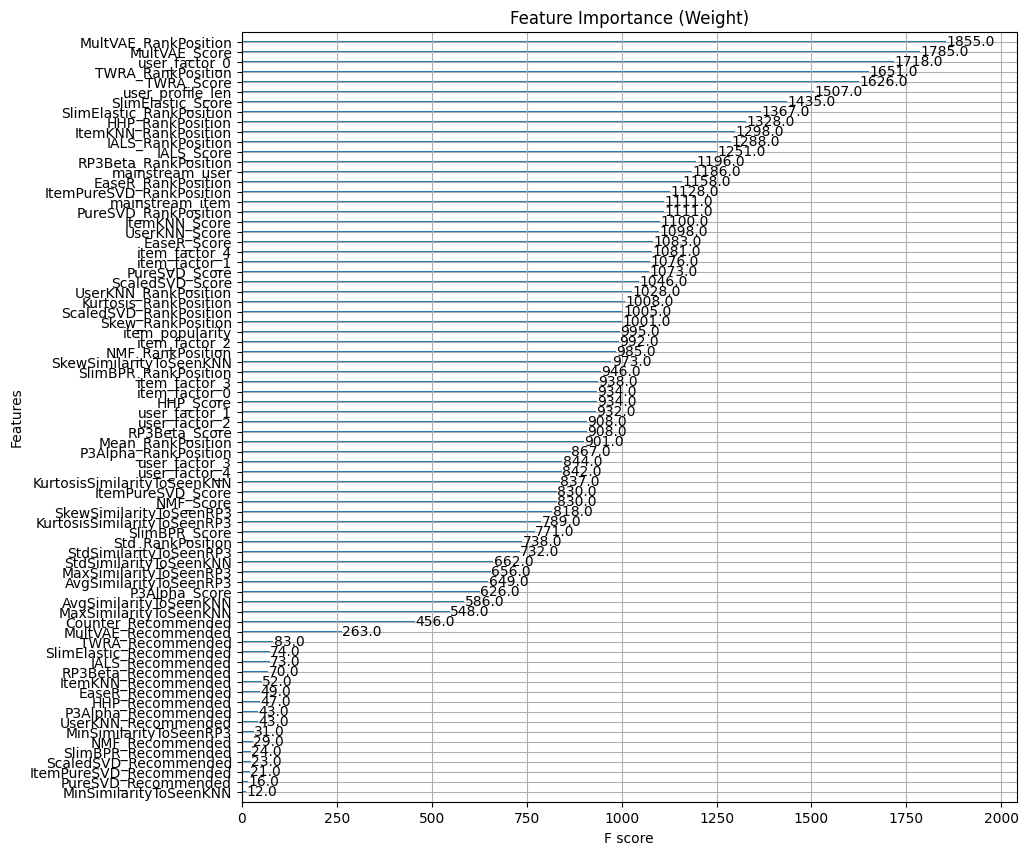

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(XGB_model, importance_type='weight', title='Feature Importance (Weight)', ax=ax)

<Axes: title={'center': 'Feature Importance (Cover)'}, xlabel='F score', ylabel='Features'>

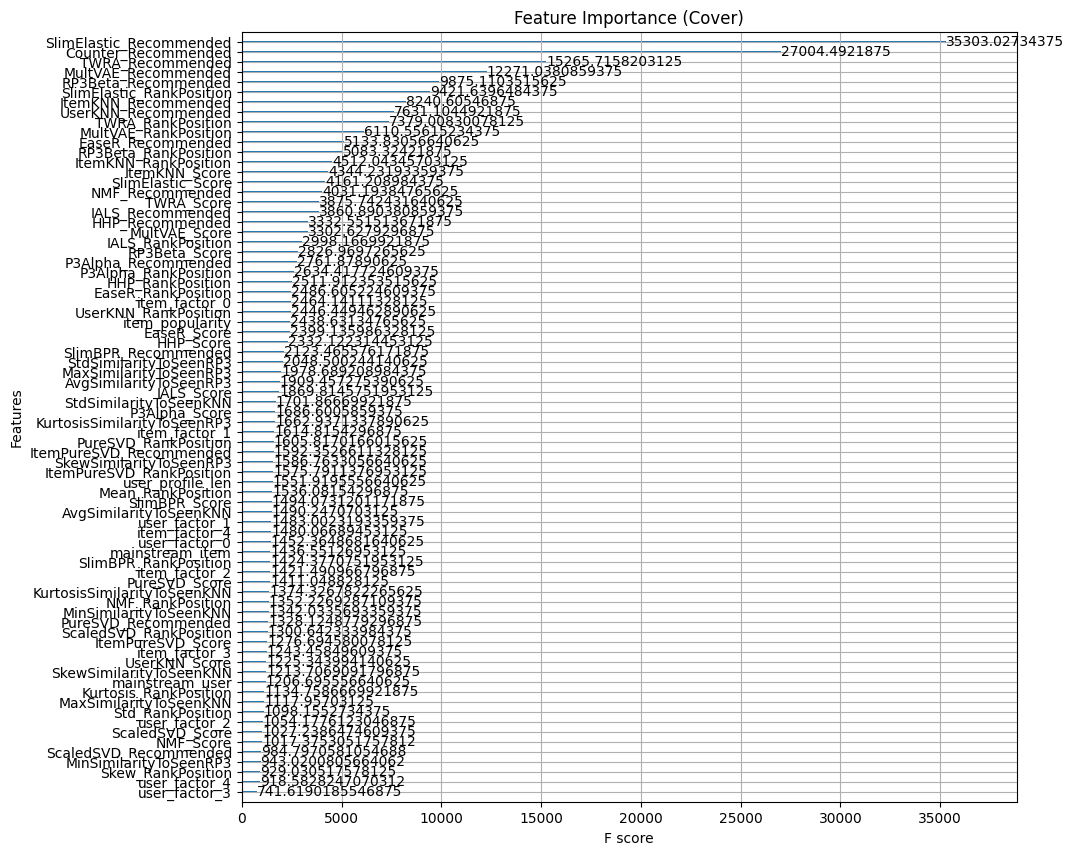

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(XGB_model, importance_type='cover', title='Feature Importance (Cover)', ax=ax)

<Axes: title={'center': 'Feature Importance (Gain)'}, xlabel='F score', ylabel='Features'>

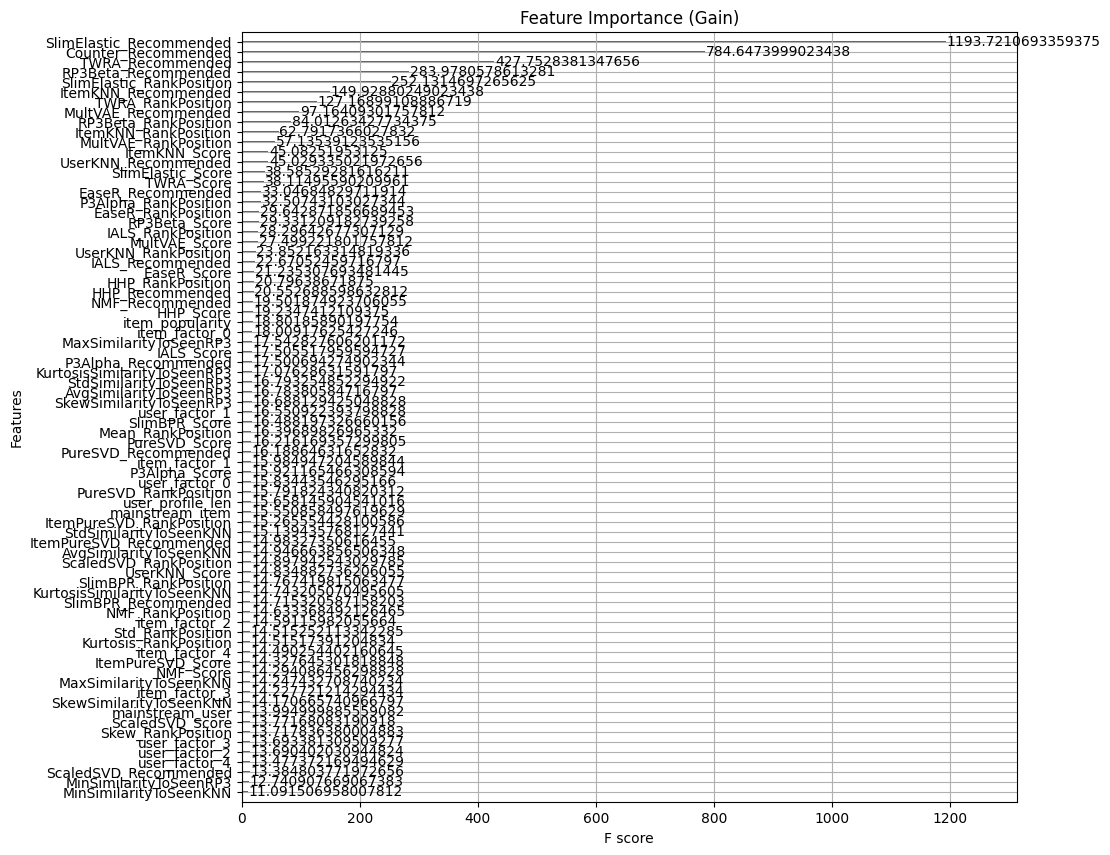

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(XGB_model, importance_type='gain', title='Feature Importance (Gain)', ax=ax)

In [68]:
recommender_item = ItemKNNCFRecommender(URM_all)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_all)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_all)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_all)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_all)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])

recommender_pure_svd_item = PureSVDItemRecommender(URM_all)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_all)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_all.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_all)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_all.zip')

recommender_slim = SLIMElasticNetRecommender(URM_all)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_all.zip')

recommender_ease_r = EASE_R_Recommender(URM_all)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_all.zip')

recommender_ials = IALSRecommender(URM_all)
recommender_ials.load_model('/kaggle/working/', 'ials_all.zip')

recommender_vae = MultVAERecommender(URM_all)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_all')

recommender_hhp = HHPRecommender(URM_all)
recommender_hhp.fit(**params_hhp)

recommender_twra = TwoWayRankAggregationRecommender(URM_all)
recommender_twra.fit(**params_twra)

# recommender_als = ALSImplicitRecommender(URM_all)
# recommender_als.load_model('/kaggle/working/', 'als_all.npz')

########################## CANDIDATE GENERATORS ##########################

recommender_slim_recall = SLIMElasticNetRecommender(URM_all)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_all.zip')

recommender_rp3_recall = RP3betaRecommender(URM_all)
recommender_rp3_recall.fit(**params_rp3_recall)

recommender_item_recall = ItemKNNCFRecommender(URM_all)
recommender_item_recall.fit(**params_item_knn_recall)

ItemKNNCFRecommender: URM Detected 386 ( 3.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 125 ( 0.6%) items with no interactions.
Similarity column 22347 (100.0%), 4204.55 column/sec. Elapsed time 5.31 sec
UserKNNCFRecommender: URM Detected 386 ( 3.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 125 ( 0.6%) items with no interactions.
Similarity column 13024 (100.0%), 3993.89 column/sec. Elapsed time 3.26 sec
RP3betaRecommender: URM Detected 386 ( 3.0%) users with no interactions.
RP3betaRecommender: URM Detected 125 ( 0.6%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2477.22 column/sec. Elapsed time 9.02 sec
P3alphaRecommender: URM Detected 386 ( 3.0%) users with no interactions.
P3alphaRecommender: URM Detected 125 ( 0.6%) items with no interactions.
P3alphaRecommender: Similarity column 22347 (100.0%), 2654.87 column/sec. Elapsed time 8.42 sec
PureSVDRecommender: URM Detected 386 ( 3.0%) users with no inter

In [69]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    'HHP': recommender_hhp,
    'TWRA': recommender_twra,
    # 'ALS': recommender_als
}

In [70]:
cutoff = 50
n_users, n_items = URM_all.shape

prediction_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
prediction_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations_slim = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    recommendations_knn = recommender_item_recall.recommend(user_id, cutoff = cutoff)
    recommendations_rp3 = recommender_rp3_recall.recommend(user_id, cutoff = cutoff)
    recommendations = np.union1d(recommendations_slim, np.union1d(recommendations_knn, recommendations_rp3))
    prediction_dataframe.loc[user_id, "ItemID"] = recommendations
    
prediction_dataframe = prediction_dataframe.explode("ItemID")

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = prediction_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        prediction_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        prediction_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        prediction_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()
    
item_item_S = recommender_item.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        prediction_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = 0
    else:
        similarities = item_item_S[prediction_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        prediction_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = similarities.mean(axis=1).flatten()
        prediction_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = similarities.max(axis=1).flatten()
        prediction_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = similarities.min(axis=1).flatten()
        prediction_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = similarities.std(axis=1).flatten()
        prediction_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
        prediction_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

item_item_S = recommender_rp3.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        prediction_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = 0
    else:
        similarities = item_item_S[prediction_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        prediction_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = similarities.mean(axis=1).flatten()
        prediction_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = similarities.max(axis=1).flatten()
        prediction_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = similarities.min(axis=1).flatten()
        prediction_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = similarities.std(axis=1).flatten()
        prediction_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = stats.skew(similarities, axis=1)
        prediction_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

prediction_dataframe = prediction_dataframe.reset_index()
prediction_dataframe = prediction_dataframe.rename(columns = {"index": "UserID"})

recommended_columns = [col for col in prediction_dataframe.columns if col.endswith('_Recommended')]
prediction_dataframe['Counter_Recommended'] = prediction_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in prediction_dataframe.columns if col.endswith('_RankPosition')]
prediction_dataframe['Mean_RankPosition'] = prediction_dataframe[position_columns].mean(axis=1)
prediction_dataframe['Std_RankPosition'] = prediction_dataframe[position_columns].std(axis=1)
prediction_dataframe['Skew_RankPosition'] = prediction_dataframe[position_columns].skew(axis=1)
prediction_dataframe['Kurtosis_RankPosition'] = prediction_dataframe[position_columns].kurtosis(axis=1)

item_popularity = np.ediff1d(sps.csc_matrix(URM_all).indptr)
item_popularity = item_popularity / np.max(item_popularity)
prediction_dataframe['item_popularity'] = item_popularity[prediction_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_all).indptr)
user_popularity = user_popularity / np.max(user_popularity)
prediction_dataframe['user_profile_len'] = user_popularity[prediction_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_all.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
prediction_dataframe['mainstream_user'] = mainstream_user[prediction_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_all.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
prediction_dataframe['mainstream_item'] = mainstream_item[prediction_dataframe["ItemID"].values.astype(int)]

user_factors_df = pd.DataFrame(user_factors_final_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_final_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_final_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_final_train[:, :5].shape[1])])

prediction_dataframe = prediction_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
prediction_dataframe = prediction_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
prediction_dataframe = prediction_dataframe.sort_values(by='UserID')

prediction_dataframe["UserID"] = prediction_dataframe["UserID"].astype(int)
prediction_dataframe["ItemID"] = prediction_dataframe["ItemID"].astype(int)
prediction_dataframe

/tmp/ipykernel_19/3716254121.py:7: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

/tmp/ipykernel_19/3716254121.py:74: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.

/tmp/ipykernel_19/3716254121.py:75: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.



,UserID,ItemID,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,P3Alpha_RankPosition,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,0,0.000000,22150.0,0.0,0.049910,120.0,0.0,0.000000,22150.0,...,0.161283,0.057150,-0.179319,-0.017929,0.058489,0.005573,0.000276,0.007794,-0.010626,-0.001530
51,0,1067,0.000000,8330.0,0.0,0.055061,102.0,0.0,0.028730,174.0,...,0.006633,0.003640,0.012813,-0.006771,0.000972,0.005573,0.000276,0.007794,-0.010626,-0.001530
50,0,1056,0.148159,35.0,0.0,0.004526,4326.0,0.0,0.084663,23.0,...,0.002581,-0.001164,0.000103,-0.001671,0.001920,0.005573,0.000276,0.007794,-0.010626,-0.001530
49,0,976,0.166684,27.0,0.0,0.174678,9.0,1.0,0.044922,63.0,...,0.007626,-0.001412,0.009353,-0.007804,0.000635,0.005573,0.000276,0.007794,-0.010626,-0.001530
48,0,921,0.159207,31.0,0.0,0.106853,16.0,0.0,0.035512,102.0,...,0.008975,-0.001250,0.012296,-0.008343,0.003286,0.005573,0.000276,0.007794,-0.010626,-0.001530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060085,13023,440,0.000000,7149.0,0.0,0.384692,27.0,0.0,0.000000,7177.0,...,0.017581,-0.029270,0.021202,0.014549,0.051794,0.009693,-0.007923,-0.000422,0.004503,0.023066
1060081,13023,346,0.087640,62.0,0.0,0.520535,7.0,1.0,0.076672,60.0,...,0.024040,-0.046680,0.024238,0.026045,0.079139,0.009693,-0.007923,-0.000422,0.004503,0.023066
1060080,13023,334,0.299805,21.0,0.0,0.400558,25.0,0.0,0.067050,72.0,...,0.023503,-0.038707,0.037088,0.024652,0.048741,0.009693,-0.007923,-0.000422,0.004503,0.023066
1060106,13023,3608,0.436101,10.0,0.0,0.359568,31.0,0.0,0.314715,18.0,...,0.003459,-0.010568,0.004390,0.002426,0.012327,0.009693,-0.007923,-0.000422,0.004503,0.023066


In [71]:
recommender = XGBoostRerankerRecommender(URM_all, XGB_model, prediction_dataframe)

In [72]:
recommendations = recommender.recommend(user_ids_test['user_id'].unique() - 1, cutoff=10, return_scores=False)
recommendations = [' '.join([str(item + 1) for item in r]).strip() for r in recommendations]

submission_df = pd.DataFrame({'user_id': user_ids_test['user_id'].unique(), 'item_list': recommendations})
display(submission_df.head())

submission_df.to_csv('/kaggle/working/submission_xgboost_no_ids.csv', index=False)

,user_id,item_list
0,1,101 36 403 506 123 515 1546 694 977 52
1,2,1095 47 12 1522 50 656 2 3176 102 949
2,3,59 259 857 239 536 584 648 956 414 4252
3,4,28 249 50 7 139 171 5 314 254 146
4,5,1570 77 131 5138 1220 1511 471 170 766 95
